Подключение необходимых библиотек

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets

Задаем нормализующие преобразования, загружаем набор MNIST и разбиваем данные на подвыборки

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
transforms.Normalize((0.0,), (1.0,))])
dataset = datasets.MNIST(root = './data', train=True, transform = transform, download=True)
train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])
test_set = datasets.MNIST(root = './data', train=False, transform = transform, download=True)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=1,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=1,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=1,shuffle=True)
print("Training data:",len(train_loader),"Validation data:",len(val_loader),"Test data:",len(test_loader))

100%|██████████| 9912422/9912422 [00:00<00:00, 123632736.75it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 95608282.42it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 74266998.10it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 22733327.89it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Training data: 50000 Validation data: 10000 Test data: 10000


Используем GPU если возможно

In [ ]:
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

Создаем класс НС на основе torch

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    output = F.log_softmax(x, dim=1)
    return output

Проверяем работоспособность созданного класса

In [ ]:
model = Net().to(device)

Создаем оптимизатор, функцию потреть и трейнер сети

In [ ]:
optimizer = optim.Adam(model.parameters(),lr=0.0001, betas=(0.9, 0.999))
criterion = nn.NLLLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

Определяем функцию обучения сети

In [ ]:
def fit(model,device,train_loader,val_loader,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label = data[0].to(device),data[1].to(device)
        output = model(input)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
        else:
          val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss


Обучаем модель

In [ ]:
loss, val_loss = fit(model, device, train_loader, val_loader, 10)

Fitting the model...


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 1 Loss: 0.25502348362023064 Val_Loss: 0.13587741836671693
Epoch: 2 Loss: 0.10483097246813873 Val_Loss: 0.10949782308520009
Epoch: 3 Loss: 0.08414511887790031 Val_Loss: 0.086180099884405
Epoch: 4 Loss: 0.07064662269476779 Val_Loss: 0.08097651216969341
Epoch: 5 Loss: 0.0675003984396047 Val_Loss: 0.08407679789471523
Epoch: 6 Loss: 0.0602858006541766 Val_Loss: 0.08038328348216324
Epoch: 7 Loss: 0.058356982779854225 Val_Loss: 0.0825257043913721
Epoch: 8 Loss: 0.057575442625518024 Val_Loss: 0.07787220595598042
Epoch: 9 Loss: 0.0545298228988369 Val_Loss: 0.08140526757751468
Epoch: 10 Loss: 0.05669650201833245 Val_Loss: 0.08202007231638436


Строим график

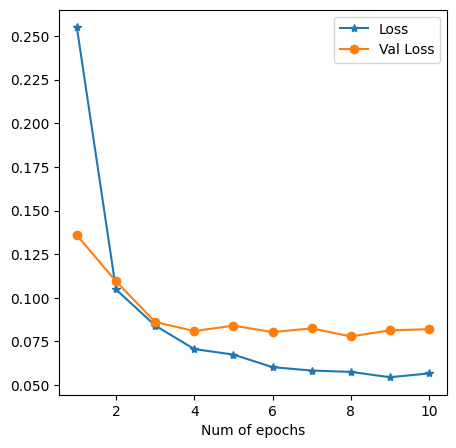

In [ ]:
fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(1,11), loss, "*-",label="Loss")
plt.plot(np.arange(1,11), val_loss,"o-",label="Val Loss")
plt.xlabel("Num of epochs")
plt.legend()
plt.show()

Создаем функцию атаки

In [ ]:
def attack(model, device, data, epsilon=0.1, alpha=0.01, num_steps=40):
    # Перевод модели в режим оценки
    model.eval()

    # Создание копии изначального тензора
    perturbed_data = data.clone().detach().to(device)

    # Установка атрибута requires_grad для оптимизации тензора
    perturbed_data.requires_grad = True

    # Создание оптимизации с помощью optim.LBFGS
    optimizer = optim.LBFGS([perturbed_data], lr=alpha)

    for _ in range(num_steps):
        def closure(): #Функция вычисления потери
            optimizer.zero_grad()

            output = model(perturbed_data)

            # Вычисление потерь
            loss = criterion(output, label)

            loss.backward()

             # Добавление помех в градиент
            grad_sign = perturbed_data.grad.sign()
            perturbed_data.grad.zero_()
            perturbed_data.grad.data.add_(epsilon * grad_sign)

            return loss

        # Выполняем шаг оптимизации
        optimizer.step(closure)

        # Ограничиваем диапазон значений
        perturbed_data = torch.clamp(perturbed_data, data - epsilon, data + epsilon)

        return perturbed_data


        # Выполняем шаг оптимизации
        optimizer.step(closure)
        optimizer.zero_grad()  # Обнуление градиента для следующего шага
        # Ограничиваем диапазон значений
        perturbed_data = torch.clamp(perturbed_data, data - epsilon, data + epsilon)

Выбор примера из тестового набора данных

In [ ]:
sample = test_set[0]
input = sample[0].unsqueeze(0).to(device)
label = torch.tensor([sample[1]]).to(device)

Выполнение атаки

In [ ]:
perturbed_input = attack(model, device, input, epsilon=0.1, alpha=0.01, num_steps=40)

Получение предсказания модели на искаженных данных

In [ ]:
perturbed_output = model(perturbed_input)

Получение индекса класса с наибольшей вероятностью

In [ ]:
_, perturbed_predicted = torch.max(perturbed_output, 1)

Выведение результаты

In [ ]:
print("Исходная метка класса:", label.item())
print("Метка класса после атаки:", perturbed_predicted.item())

Исходная метка класса: 7
Метка класса после атаки: 7
